<a href="https://colab.research.google.com/github/BobLiuGZ/time-series-analysis/blob/master/Out_SVM_paper_condition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

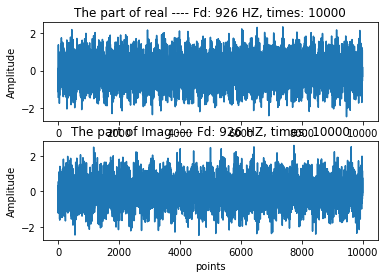

(10000, 1)


In [24]:
#!/usr/bin/env python
# coding: utf-8

# In[2]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, LSTM, CuDNNLSTM
from tensorflow.keras.models import Sequential, load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR








config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)


# In[5]:
# The Generation of Multiple Uncorrelated Rayleigh Fading Waveforms
def Rayleigh(fd, time):
    '''
    改进的jakes模型来产生单径的平坦型瑞利衰落信道
    :param Fd: 信道的最大多普勒频移 单位Hz
    :param T: 信号的抽样时间序列，抽样间隔单位s
    :return data: 为输出的瑞利信道函数，是一个时间函数复序列

    '''
    np.random.seed(2019+1)
    t = []
    alfa = []
    for i in range(1, time + 1):
        t.append(i)

    length = len(t)
    # 假设的入射波数目
    n = 40
    # 每象限的入射波数目即振荡器数目
    n0 = n // 4

    wm = 2 * math.pi * fd
    # 信道函数的实部
    tc = np.zeros((1, length))
    # 信道函数的虚部
    ts = np.zeros((1, length))
    # 归一化功率系数
    p_nor = math.sqrt(1 / n0)
    # 区别个条路径的均匀分布随机相位
    theta = 2 * math.pi * np.random.rand(1, 1) - math.pi
    for ii in range(1, n0 + 1):
        # 第i条入射波的入射角
        alfa.append((2 * math.pi * ii - math.pi + theta) / n)
        # 对每个子载波而言在(-pi,pi)之间均匀分布的随机相位
        fi_tc = 2 * math.pi + np.random.rand(1, 1) - math.pi
        fi_ts = 2 * math.pi + np.random.rand(1, 1) - math.pi
        # 计算冲激响应函数
        tc = tc + np.cos(math.cos(alfa[ii - 1]) * wm * np.array(t) + fi_tc)
        ts = ts + np.cos(math.sin(alfa[ii - 1]) * wm * np.array(t) + fi_ts)

    # 乘归一化功率系数得到传输函数
    ray_data = p_nor * (tc + 1j * ts)

    return ray_data


# The plot of Real and Image part of Raleigh Fading Channel
fd = 926
t = 10000
data = Rayleigh(fd, t)
# print(Rdata.tpye)
real = data.real
imag = data.imag
plt.subplot(211)
plt.plot(real[0])
plt.xlabel('points')
plt.ylabel('Amplitude')
plt.title('The part of real ---- Fd: ' + str(fd) + ' HZ, times: ' + str(t))
plt.subplot(212)
plt.plot(imag[0])
plt.xlabel('points')
plt.ylabel('Amplitude')
plt.title('The part of Imag ---- Fd: ' + str(fd) + ' HZ, times: ' + str(t))
plt.show()

# In[6]:

Rdata = real[0].reshape(-1, 1)
print(np.shape(Rdata))
scaler = MinMaxScaler(feature_range=(0, 1))
Rdata = scaler.fit_transform(Rdata)

# In[7]:


# split into training and test
train_size = int(len(Rdata) * 0.9)
test_size = len(Rdata) - train_size
# predict_size = len(Rdata) - train_size
train, test = Rdata[0:train_size, :], Rdata[train_size:len(Rdata), :]


# In[8]:


# convert data into training dataset and Label dataset
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


# In[9]:


look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))




In [25]:
# training the SVR model
def model_building():
    model = SVR()
    return model


model = model_building()
model.fit(trainX, trainY)
print(model.get_params())
pred_n = model.predict(testX)



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'auto_deprecated', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [0]:
testY = scaler.inverse_transform([testY])
pred_n = scaler.inverse_transform([pred_n])



<class 'numpy.ndarray'>


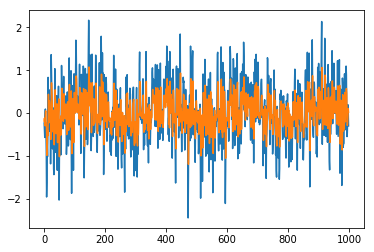

In [38]:
print(type(testY))
plt.plot(testY[0,:])
plt.plot(pred_n[0, :])
plt.show()

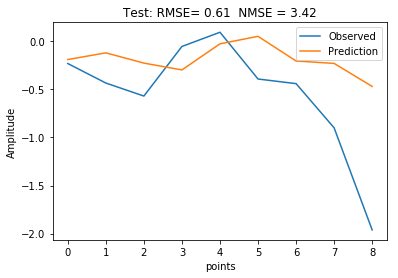

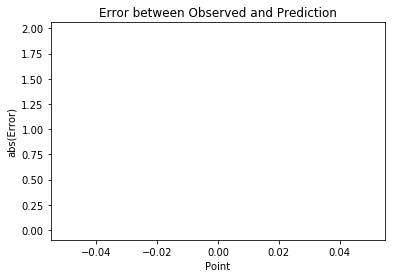

In [44]:



# The Normalised Mean Square Error from Paper  Two
def NMSE_q(p, m):
    n = len(p)
    p0 = sum(p) / n
    m0 = sum(m) / n
    nmse = np.mean((p - m) ** 2) / (p0 * m0)
    return nmse


NMSE = NMSE_q(testY[0, 0:9], pred_n[0, 0:9])
PreScore = math.sqrt(np.mean(mean_squared_error(testY[0, :], pred_n[0, :])))
x_axis = np.arange(len(pred_n))
# print('Test Score: %.2f RMSE' % (PreScore))
plt.figure(2)
plt.title('Test: RMSE= %.2f' % (PreScore) + '  NMSE = %.2f' % (NMSE))
#plt.title('The '+ str(i+1) + 'th Test: RMSE= %.2f' % (PreScore) + '  NMSE = %.2f' % (NMSE))
plt.plot(testY[0,0:9])
plt.plot(pred_n[0, 0:9])
#plt.xticks(np.array(range(pred_n)))
plt.xlabel('points')
plt.ylabel('Amplitude')
plt.legend(['Observed', 'Prediction'], loc='best')
plt.figure(3)
plt.title('Error between Observed and Prediction')
plt.xlabel('Point')

#plt.xticks(np.array(range(pred_n)))
plt.ylabel('abs(Error)')
plt.plot(x_axis, abs(pred_n - testY))
plt.show()
